## 📦 Setup e Importazioni

# 🎯 Contrarian Strategy with Volatility Scaling

Sistema di trading quantitativo **CONTRARIAN con VOLATILITY TARGETING** per 22 coppie valutarie forex.

**Strategia Enhanced Contrarian:**
- Base: Mean reversion (long perdenti, short vincitori)
- Enhancement: **Volatility scaling** per ridurre esposizione durante alta volatilità
- Target volatility: 12% annualizzato
- Scaling factor dinamico basato su rolling volatility

---

In [ ]:
# Importazioni
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Aggiungi percorso moduli
sys.path.append('../core')

# Importa moduli core
from data_loader import load_forex_data, get_currency_pairs
from signal_generator import generate_momentum_signals, validate_signals
from backtest_engine import BacktestEngine

# Configurazione matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Setup completato con successo!")

✅ Setup completato con successo!


## 📊 Caricamento Dati e Configurazione

In [ ]:
# Carica dati forex
print("🔄 Caricamento dati forex...")
data = load_forex_data('../data/forex_extended_data.parquet')

# Configurazione strategia
lookback_days = 30  # Lookback per momentum signals
vol_window = 30      # Finestra per volatility calculation
target_vol = 0.05    # Target volatility (10% annualizzato)
min_scale = 0.05     # Scaling minimo (5%)
max_scale = 1        # Scaling massimo (100%)

print(f"✅ Configurazione:")
print(f"   • Lookback momentum: {lookback_days} giorni")
print(f"   • Finestra volatility: {vol_window} giorni")
print(f"   • Target volatility: {target_vol*100:.1f}%")
print(f"   • Scaling range: {min_scale*100:.0f}% - {max_scale*100:.0f}%")

🔄 Caricamento dati forex...
✓ Loaded forex data: 6667 days, 154 columns
✓ Date range: 2000-01-03 to 2025-08-03
✅ Configurazione:
   • Lookback momentum: 30 giorni
   • Finestra volatility: 30 giorni
   • Target volatility: 5.0%
   • Scaling range: 5% - 100%


## 🔄 Generazione Segnali Contrarian Base

In [3]:
# Genera segnali momentum e li inverte per contrarian
print(f"🔄 Generazione segnali contrarian base...")
momentum_signals = generate_momentum_signals(
    price_data=data,
    lookback_days=lookback_days,
    top_n=5,
    rebalance_freq='weekly'
)

# Inverti segnali per strategia contrarian
contrarian_base = momentum_signals.copy() * -1

print(f"✅ Segnali contrarian base generati")
print(f"   • Segnali long: {(contrarian_base == 0.2).sum().sum():,}")
print(f"   • Segnali short: {(contrarian_base == -0.2).sum().sum():,}")
print(f"   • Esposizione media: {abs(contrarian_base).sum(axis=1).mean():.2f} (200% gross)")

🔄 Generazione segnali contrarian base...
✓ Generated momentum signals: 30d lookback, 5 long + 5 short
✓ Rebalancing: weekly
✓ Signal range: 2000-01-03 to 2025-08-03
✅ Segnali contrarian base generati
   • Segnali long: 33,315
   • Segnali short: 33,315
   • Esposizione media: 2.00 (200% gross)


## 🎯 Implementazione Volatility Scaling

In [4]:
def calculate_portfolio_volatility(price_data, signals, vol_window=30):
    """
    Calcola la volatilità rolling del portafoglio.
    
    Parameters:
    -----------
    price_data : pd.DataFrame
        Dati prezzi con colonne per ogni currency pair
    signals : pd.DataFrame  
        Segnali di trading (pesi)
    vol_window : int
        Finestra per calcolo volatilità rolling
        
    Returns:
    --------
    pd.Series
        Volatilità annualizzata del portafoglio
    """
    # Estrai pairs comuni
    pairs = [col.replace('_weight', '') for col in signals.columns if col.endswith('_weight')]
    
    # Calcola rendimenti giornalieri per ogni pair
    portfolio_returns = pd.Series(0.0, index=signals.index)
    
    for pair in pairs:
        # Cerca colonna close per questo pair
        close_col = None
        for col in price_data.columns:
            if pair in col and 'close' in col.lower():
                close_col = col
                break
        
        if close_col is not None:
            # Calcola returns per questo pair
            pair_returns = price_data[close_col].pct_change()
            
            # Peso del pair nel portafoglio
            weight_col = f"{pair}_weight"
            if weight_col in signals.columns:
                # Contributo al return del portafoglio
                contribution = pair_returns * signals[weight_col].shift(1)  # Use lagged weights
                portfolio_returns += contribution.fillna(0)
    
    # Calcola volatilità rolling annualizzata
    rolling_vol = portfolio_returns.rolling(vol_window).std() * np.sqrt(252)
    
    return rolling_vol

def apply_volatility_scaling(base_signals, portfolio_vol, target_vol=0.12, 
                           min_scale=0.2, max_scale=1.5):
    """
    Applica volatility scaling ai segnali base.
    
    Parameters:
    -----------
    base_signals : pd.DataFrame
        Segnali contrarian base
    portfolio_vol : pd.Series
        Volatilità rolling del portafoglio
    target_vol : float
        Volatilità target (es. 0.12 = 12%)
    min_scale : float
        Scaling factor minimo
    max_scale : float
        Scaling factor massimo
        
    Returns:
    --------
    tuple
        (scaled_signals, scaling_factors)
    """
    # Calcola scaling factor
    scaling_factors = target_vol / portfolio_vol
    
    # Applica limiti di scaling
    scaling_factors = scaling_factors.clip(min_scale, max_scale)
    
    # Gestisci NaN e inf
    scaling_factors = scaling_factors.fillna(1.0)
    scaling_factors = scaling_factors.replace([np.inf, -np.inf], 1.0)
    
    # Applica scaling ai segnali
    scaled_signals = base_signals.copy()
    
    for col in scaled_signals.columns:
        scaled_signals[col] = base_signals[col] * scaling_factors
    
    # Assicurati che i segnali rimangano entro range ragionevoli
    scaled_signals = scaled_signals.clip(-0.3, 0.3)  # Max 30% per posizione
    
    return scaled_signals, scaling_factors

print("✅ Funzioni volatility scaling definite")

✅ Funzioni volatility scaling definite


## 📈 Calcolo Volatilità e Scaling

In [5]:
# Calcola volatilità del portafoglio contrarian base
print("🔄 Calcolo volatilità portafoglio...")
portfolio_vol = calculate_portfolio_volatility(data, contrarian_base, vol_window)

# Applica volatility scaling
print("🎯 Applicazione volatility scaling...")
contrarian_scaled, scaling_factors = apply_volatility_scaling(
    contrarian_base, portfolio_vol, target_vol, min_scale, max_scale
)

# Statistiche scaling
valid_scaling = scaling_factors.dropna()
print(f"\n📊 Statistiche Volatility Scaling:")
print(f"   • Volatilità media portafoglio: {portfolio_vol.mean()*100:.2f}%")
print(f"   • Volatilità mediana: {portfolio_vol.median()*100:.2f}%")
print(f"   • Scaling factor medio: {valid_scaling.mean():.3f}")
print(f"   • Scaling factor mediano: {valid_scaling.median():.3f}")
print(f"   • Min scaling applicato: {valid_scaling.min():.3f} ({valid_scaling.min()*100:.0f}%)")
print(f"   • Max scaling applicato: {valid_scaling.max():.3f} ({valid_scaling.max()*100:.0f}%)")

# Confronto esposizione
base_exposure = abs(contrarian_base).sum(axis=1)
scaled_exposure = abs(contrarian_scaled).sum(axis=1)

print(f"\n📈 Confronto Esposizione:")
print(f"   • Esposizione base media: {base_exposure.mean():.3f}")
print(f"   • Esposizione scaled media: {scaled_exposure.mean():.3f}")
print(f"   • Riduzione esposizione: {(1 - scaled_exposure.mean()/base_exposure.mean())*100:.1f}%")

🔄 Calcolo volatilità portafoglio...
🎯 Applicazione volatility scaling...

📊 Statistiche Volatility Scaling:
   • Volatilità media portafoglio: 11.26%
   • Volatilità mediana: 10.20%
   • Scaling factor medio: 0.548
   • Scaling factor mediano: 0.491
   • Min scaling applicato: 0.061 (6%)
   • Max scaling applicato: 1.000 (100%)

📈 Confronto Esposizione:
   • Esposizione base media: 1.999
   • Esposizione scaled media: 1.094
   • Riduzione esposizione: 45.3%


## 🚀 Backtesting Comparativo

In [6]:
# Backtest strategia contrarian BASE
print("⚡ Backtest strategia contrarian BASE...")
engine_base = BacktestEngine(initial_capital=100000, leverage=1.0)
start_time = datetime.now()
results_base = engine_base.run_backtest(data, contrarian_base, verbose=False)
time_base = (datetime.now() - start_time).total_seconds()

# Backtest strategia contrarian VOLATILITY SCALED
print("⚡ Backtest strategia contrarian VOL-SCALED...")
engine_scaled = BacktestEngine(initial_capital=100000, leverage=1.0)
start_time = datetime.now()
results_scaled = engine_scaled.run_backtest(data, contrarian_scaled, verbose=False)
time_scaled = (datetime.now() - start_time).total_seconds()

print(f"\n✅ Backtesting completato!")
print(f"   • Contrarian Base: {time_base:.2f}s")
print(f"   • Contrarian Vol-Scaled: {time_scaled:.2f}s")

INFO:backtest_engine:BacktestEngine initialized with 100,000 starting capital
INFO:backtest_engine:Detected 22 currency pairs
INFO:backtest_engine:Price data range: 2000-01-03 00:00:00+00:00 to 2025-08-03 00:00:00+01:00
INFO:backtest_engine:Signals data range: 2000-01-03 00:00:00+00:00 to 2025-08-03 00:00:00+01:00
INFO:backtest_engine:Calculating daily returns...
INFO:backtest_engine:Calculated returns for 22 pairs


⚡ Backtest strategia contrarian BASE...


INFO:backtest_engine:Calculating performance metrics...
INFO:backtest_engine:BacktestEngine initialized with 100,000 starting capital
INFO:backtest_engine:Detected 22 currency pairs
INFO:backtest_engine:Price data range: 2000-01-03 00:00:00+00:00 to 2025-08-03 00:00:00+01:00
INFO:backtest_engine:Signals data range: 2000-01-03 00:00:00+00:00 to 2025-08-03 00:00:00+01:00
INFO:backtest_engine:Calculating daily returns...
INFO:backtest_engine:Calculated returns for 22 pairs
INFO:backtest_engine:Calculating performance metrics...


⚡ Backtest strategia contrarian VOL-SCALED...

✅ Backtesting completato!
   • Contrarian Base: 3.34s
   • Contrarian Vol-Scaled: 0.05s


## 📊 Performance Comparison

In [7]:
# Estrai metriche per confronto
metrics_base = engine_base.performance_metrics
metrics_scaled = engine_scaled.performance_metrics

print("="*90)
print(f"📊 CONTRARIAN vs VOL-SCALED CONTRARIAN - {lookback_days}D Strategy")
print("="*90)

print(f"\n{'METRICA':<30} {'BASE':<15} {'VOL-SCALED':<15} {'IMPROVEMENT':<15}")
print("-"*85)

# Confronto metriche chiave
metrics_to_compare = [
    ('Total Return (%)', 'Total Return (%)'),
    ('Annualized Return (%)', 'Annualized Return (%)'),
    ('Annualized Volatility (%)', 'Volatilità (%)'),
    ('Sharpe Ratio', 'Sharpe Ratio'),
    ('Maximum Drawdown (%)', 'Max Drawdown (%)'),
    ('Win Rate (%)', 'Win Rate (%)'),
    ('Sortino Ratio', 'Sortino Ratio'),
    ('Calmar Ratio', 'Calmar Ratio')
]

for metric_key, display_name in metrics_to_compare:
    base_val = metrics_base[metric_key]
    scaled_val = metrics_scaled[metric_key]
    
    # Calcola improvement
    if 'Drawdown' in metric_key or 'Volatility' in metric_key:
        # Per drawdown e volatility, miglioramento = riduzione
        improvement = base_val - scaled_val
        improvement_str = f"{improvement:+.2f}"
    else:
        # Per altre metriche, miglioramento = aumento
        improvement = scaled_val - base_val
        improvement_str = f"{improvement:+.2f}"
    
    print(f"{display_name:<30} {base_val:<15.2f} {scaled_val:<15.2f} {improvement_str:<15}")

print("\n" + "="*90)

# Valori finali portfolio
final_base = engine_base.portfolio_value.iloc[-1]
final_scaled = engine_scaled.portfolio_value.iloc[-1]

print(f"\n💰 RISULTATI FINALI:")
print(f"   • Portfolio Contrarian Base: ${final_base:,.0f}")
print(f"   • Portfolio Vol-Scaled: ${final_scaled:,.0f}")
print(f"   • Differenza: ${final_scaled - final_base:+,.0f}")

if final_scaled > final_base:
    improvement = ((final_scaled / final_base) - 1) * 100
    print(f"\n🎯 VOL-SCALING ha migliorato la performance!")
    print(f"   • Miglioramento: +{improvement:.1f}%")
else:
    decline = ((final_base / final_scaled) - 1) * 100
    print(f"\n📉 VOL-SCALING ha ridotto la performance di {decline:.1f}%")
    print(f"   • Ma probabilmente ha migliorato il risk-adjusted return!")

📊 CONTRARIAN vs VOL-SCALED CONTRARIAN - 30D Strategy

METRICA                        BASE            VOL-SCALED      IMPROVEMENT    
-------------------------------------------------------------------------------------
Total Return (%)               93.39           26.19           -67.19         
Annualized Return (%)          3.38            1.18            -2.20          
Volatilità (%)                 15.03           5.53            +9.50          
Sharpe Ratio                   0.09            -0.15           -0.24          
Max Drawdown (%)               35.90           14.56           +21.34         
Win Rate (%)                   50.55           50.55           +0.00          
Sortino Ratio                  0.13            -0.23           -0.36          
Calmar Ratio                   0.09            0.08            -0.01          


💰 RISULTATI FINALI:
   • Portfolio Contrarian Base: $193,387
   • Portfolio Vol-Scaled: $126,194
   • Differenza: $-67,193

📉 VOL-SCALING ha ridott

## 📈 Visualizzazioni Comparative

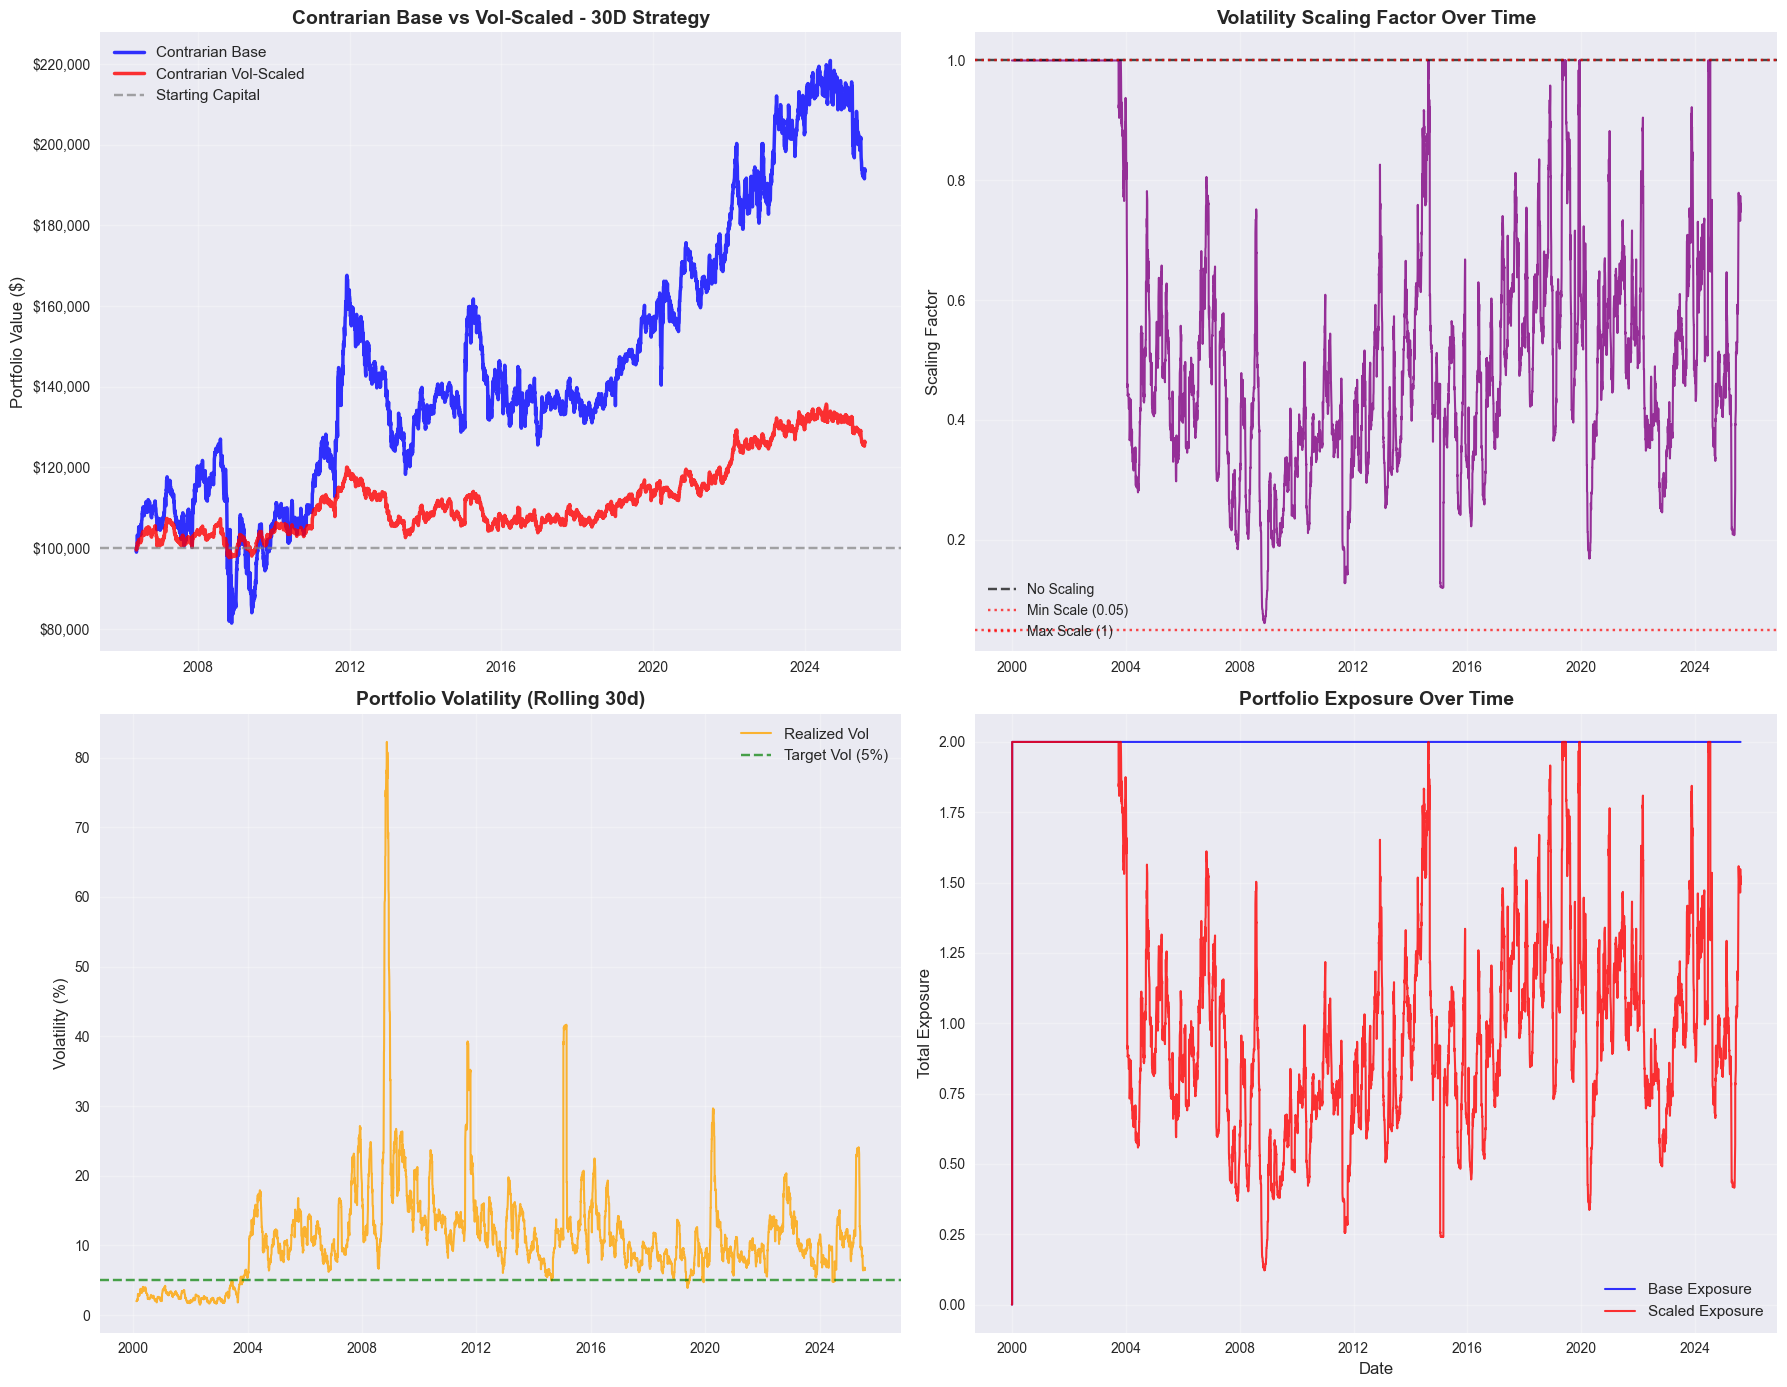

📈 Analisi vol-scaling visualizzata


In [8]:
# 1. EQUITY CURVES + SCALING FACTOR
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# Equity curves
ax1.plot(engine_base.portfolio_value.index, engine_base.portfolio_value.values, 
         linewidth=2.5, color='blue', label='Contrarian Base', alpha=0.8)
ax1.plot(engine_scaled.portfolio_value.index, engine_scaled.portfolio_value.values, 
         linewidth=2.5, color='red', label='Contrarian Vol-Scaled', alpha=0.8)
ax1.axhline(y=100000, color='gray', linestyle='--', alpha=0.7, label='Starting Capital')
ax1.set_title(f'Contrarian Base vs Vol-Scaled - {lookback_days}D Strategy', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Scaling factor over time
ax2.plot(scaling_factors.index, scaling_factors.values, 
         linewidth=1.5, color='purple', alpha=0.8)
ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='No Scaling')
ax2.axhline(y=min_scale, color='red', linestyle=':', alpha=0.7, label=f'Min Scale ({min_scale})')
ax2.axhline(y=max_scale, color='red', linestyle=':', alpha=0.7, label=f'Max Scale ({max_scale})')
ax2.set_title('Volatility Scaling Factor Over Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Scaling Factor', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Portfolio volatility
ax3.plot(portfolio_vol.index, portfolio_vol.values * 100, 
         linewidth=1.5, color='orange', alpha=0.8, label='Realized Vol')
ax3.axhline(y=target_vol*100, color='green', linestyle='--', 
           alpha=0.7, label=f'Target Vol ({target_vol*100:.0f}%)')
ax3.set_title(f'Portfolio Volatility (Rolling {vol_window}d)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Volatility (%)', fontsize=12)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Exposure comparison
ax4.plot(base_exposure.index, base_exposure.values, 
         linewidth=1.5, color='blue', alpha=0.8, label='Base Exposure')
ax4.plot(scaled_exposure.index, scaled_exposure.values, 
         linewidth=1.5, color='red', alpha=0.8, label='Scaled Exposure')
ax4.set_title('Portfolio Exposure Over Time', fontsize=14, fontweight='bold')
ax4.set_ylabel('Total Exposure', fontsize=12)
ax4.set_xlabel('Date', fontsize=12)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Analisi vol-scaling visualizzata")

## 📊 Drawdown Analysis

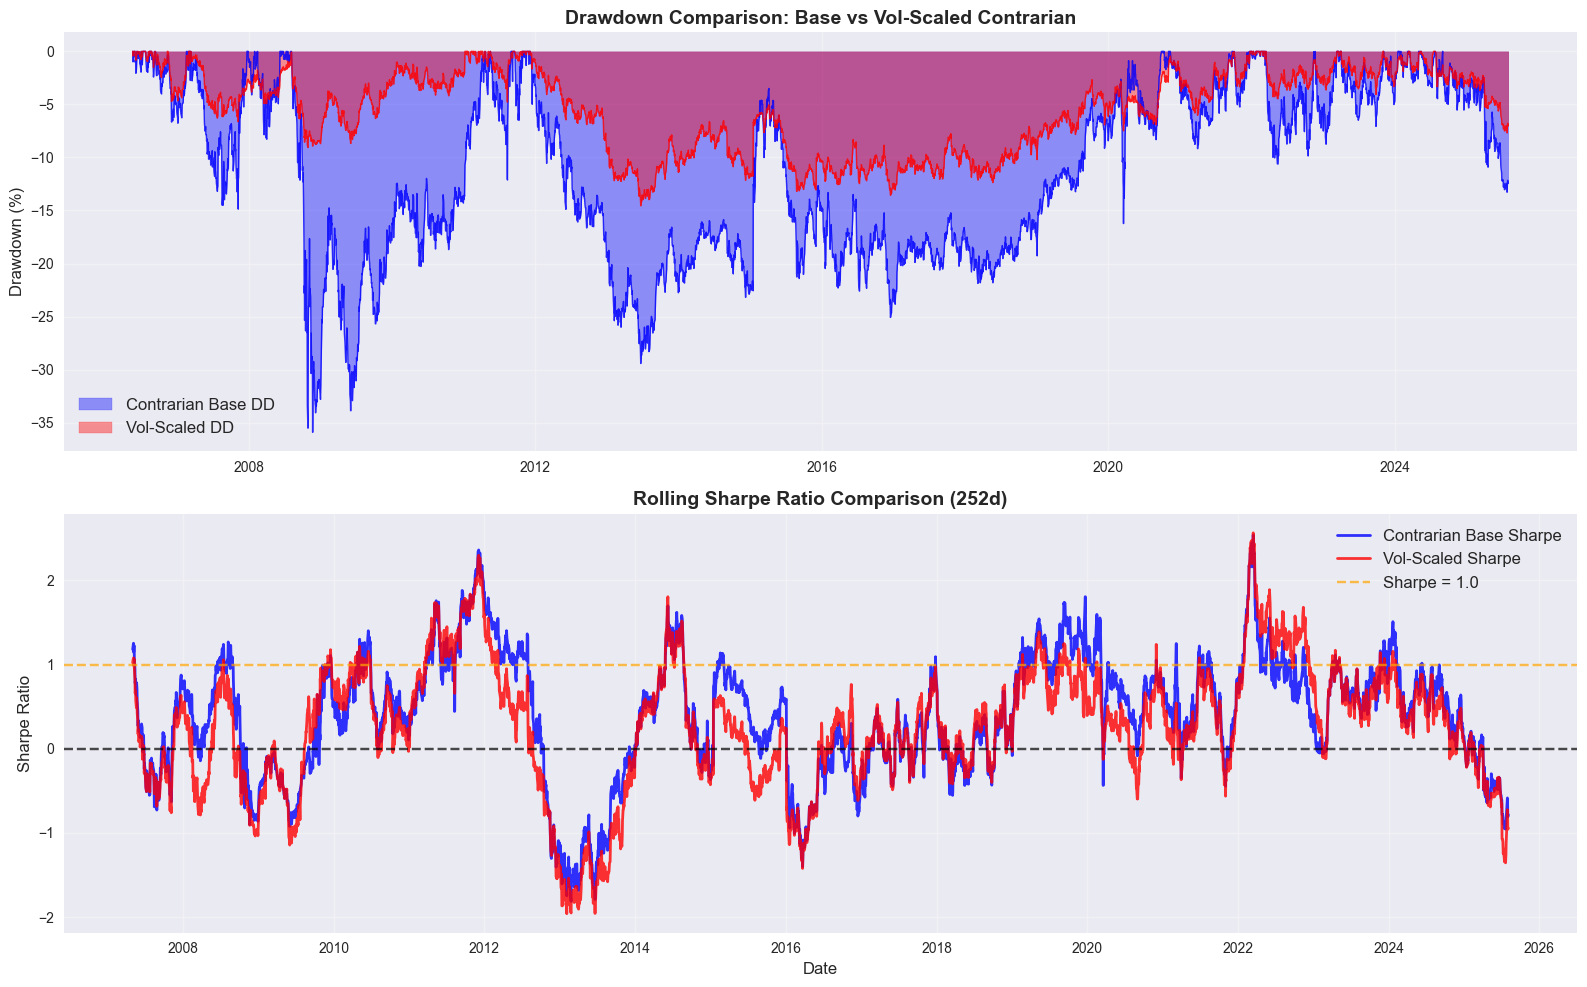

📊 Analisi drawdown completata


In [9]:
# Calcola drawdowns
cum_ret_base = (1 + engine_base.portfolio_returns).cumprod()
drawdown_base = (cum_ret_base / cum_ret_base.expanding().max() - 1) * 100

cum_ret_scaled = (1 + engine_scaled.portfolio_returns).cumprod()
drawdown_scaled = (cum_ret_scaled / cum_ret_scaled.expanding().max() - 1) * 100

# Visualizzazione drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Confronto drawdown
ax1.fill_between(drawdown_base.index, drawdown_base.values, 0, 
                alpha=0.4, color='blue', label='Contrarian Base DD')
ax1.fill_between(drawdown_scaled.index, drawdown_scaled.values, 0, 
                alpha=0.4, color='red', label='Vol-Scaled DD')
ax1.plot(drawdown_base.index, drawdown_base.values, color='blue', linewidth=1, alpha=0.8)
ax1.plot(drawdown_scaled.index, drawdown_scaled.values, color='red', linewidth=1, alpha=0.8)
ax1.set_title('Drawdown Comparison: Base vs Vol-Scaled Contrarian', fontsize=14, fontweight='bold')
ax1.set_ylabel('Drawdown (%)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Rolling Sharpe ratio comparison
window_sharpe = 252  # 1 anno
base_rolling_ret = engine_base.portfolio_returns.rolling(window_sharpe).mean() * 252
base_rolling_vol = engine_base.portfolio_returns.rolling(window_sharpe).std() * np.sqrt(252)
base_rolling_sharpe = base_rolling_ret / base_rolling_vol

scaled_rolling_ret = engine_scaled.portfolio_returns.rolling(window_sharpe).mean() * 252
scaled_rolling_vol = engine_scaled.portfolio_returns.rolling(window_sharpe).std() * np.sqrt(252)
scaled_rolling_sharpe = scaled_rolling_ret / scaled_rolling_vol

ax2.plot(base_rolling_sharpe.index, base_rolling_sharpe.values, 
         color='blue', linewidth=2, label='Contrarian Base Sharpe', alpha=0.8)
ax2.plot(scaled_rolling_sharpe.index, scaled_rolling_sharpe.values, 
         color='red', linewidth=2, label='Vol-Scaled Sharpe', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='Sharpe = 1.0')
ax2.set_title('Rolling Sharpe Ratio Comparison (252d)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Analisi drawdown completata")

## 📊 Regime Analysis

In [10]:
# Analisi per regimi di volatilità
vol_percentiles = portfolio_vol.quantile([0.25, 0.5, 0.75])

print(f"📊 ANALISI PER REGIMI DI VOLATILITÀ")
print(f"="*60)
print(f"Soglie volatilità:")
print(f"   • Q1 (Low Vol): {vol_percentiles[0.25]*100:.2f}%")
print(f"   • Q2 (Med Vol): {vol_percentiles[0.5]*100:.2f}%")
print(f"   • Q3 (High Vol): {vol_percentiles[0.75]*100:.2f}%")

# Classifica regimi
regimes = pd.cut(portfolio_vol, 
                bins=[0, vol_percentiles[0.25], vol_percentiles[0.75], float('inf')],
                labels=['Low Vol', 'Medium Vol', 'High Vol'])

# Performance per regime
base_returns = engine_base.portfolio_returns
scaled_returns = engine_scaled.portfolio_returns

print(f"\nPERFORMANCE PER REGIME:")
print(f"-"*60)

for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
    regime_mask = (regimes == regime)
    
    if regime_mask.sum() > 0:
        base_regime_ret = base_returns[regime_mask].mean() * 252 * 100
        scaled_regime_ret = scaled_returns[regime_mask].mean() * 252 * 100
        
        base_regime_vol = base_returns[regime_mask].std() * np.sqrt(252) * 100
        scaled_regime_vol = scaled_returns[regime_mask].std() * np.sqrt(252) * 100
        
        base_sharpe = base_regime_ret / base_regime_vol if base_regime_vol > 0 else 0
        scaled_sharpe = scaled_regime_ret / scaled_regime_vol if scaled_regime_vol > 0 else 0
        
        print(f"\n{regime} ({regime_mask.sum()} giorni):")
        print(f"   Base    - Return: {base_regime_ret:6.2f}%  Vol: {base_regime_vol:6.2f}%  Sharpe: {base_sharpe:6.3f}")
        print(f"   Scaled  - Return: {scaled_regime_ret:6.2f}%  Vol: {scaled_regime_vol:6.2f}%  Sharpe: {scaled_sharpe:6.3f}")
        print(f"   Improve - Return: {scaled_regime_ret-base_regime_ret:+6.2f}%  Vol: {scaled_regime_vol-base_regime_vol:+6.2f}%  Sharpe: {scaled_sharpe-base_sharpe:+6.3f}")

# Scaling statistics per regime
print(f"\nSCALING STATISTICS PER REGIME:")
print(f"-"*60)

for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
    regime_mask = (regimes == regime)
    
    if regime_mask.sum() > 0:
        regime_scaling = scaling_factors[regime_mask]
        print(f"\n{regime}:")
        print(f"   • Scaling medio: {regime_scaling.mean():.3f}")
        print(f"   • Scaling min: {regime_scaling.min():.3f}")
        print(f"   • Scaling max: {regime_scaling.max():.3f}")
        print(f"   • % giorni con scaling < 1: {(regime_scaling < 1).mean()*100:.1f}%")
        print(f"   • % giorni con scaling > 1: {(regime_scaling > 1).mean()*100:.1f}%")

📊 ANALISI PER REGIMI DI VOLATILITÀ
Soglie volatilità:
   • Q1 (Low Vol): 7.62%
   • Q2 (Med Vol): 10.20%
   • Q3 (High Vol): 13.50%

PERFORMANCE PER REGIME:
------------------------------------------------------------

Low Vol (1660 giorni):
   Base    - Return:   4.21%  Vol:   6.53%  Sharpe:  0.645
   Scaled  - Return:   2.53%  Vol:   5.13%  Sharpe:  0.493
   Improve - Return:  -1.68%  Vol:  -1.40%  Sharpe: -0.151

Medium Vol (3318 giorni):
   Base    - Return:   1.17%  Vol:  10.46%  Sharpe:  0.111
   Scaled  - Return:   0.21%  Vol:   5.26%  Sharpe:  0.039
   Improve - Return:  -0.96%  Vol:  -5.20%  Sharpe: -0.072

High Vol (1660 giorni):
   Base    - Return:  10.88%  Vol:  22.95%  Sharpe:  0.474
   Scaled  - Return:   2.99%  Vol:   6.15%  Sharpe:  0.486
   Improve - Return:  -7.90%  Vol: -16.80%  Sharpe: +0.012

SCALING STATISTICS PER REGIME:
------------------------------------------------------------

Low Vol:
   • Scaling medio: 0.911
   • Scaling min: 0.656
   • Scaling max: 1.00

## 📈 Equity Curve Vol-Scaled - Vista Dettagliata

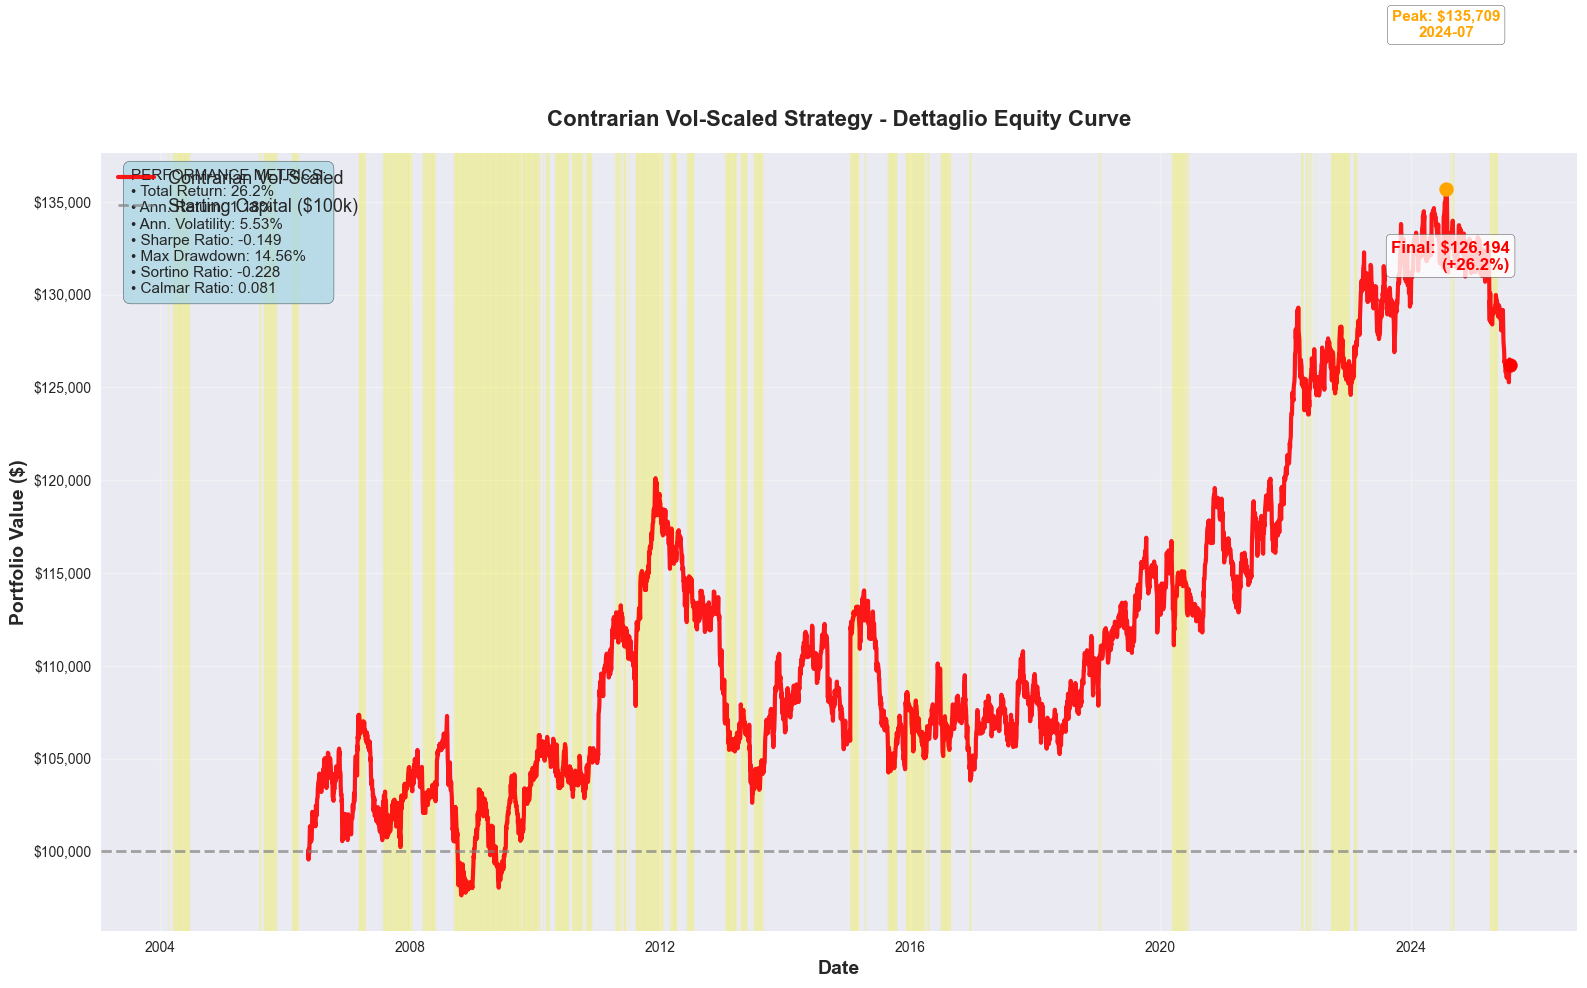

📈 Equity curve vol-scaled isolata - Portfolio finale: $126,194


In [11]:
# Plot isolato dell'equity curve vol-scaled con vista dettagliata
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Plot principale vol-scaled
vol_scaled_values = engine_scaled.portfolio_value.values
vol_scaled_dates = engine_scaled.portfolio_value.index

ax.plot(vol_scaled_dates, vol_scaled_values, 
        linewidth=3, color='red', label='Contrarian Vol-Scaled', alpha=0.9)

# Linea capitale iniziale
ax.axhline(y=100000, color='gray', linestyle='--', alpha=0.7, 
           linewidth=2, label='Starting Capital ($100k)')

# Evidenzia punti chiave
final_value = vol_scaled_values[-1]
peak_value = vol_scaled_values.max()
peak_date = vol_scaled_dates[np.argmax(vol_scaled_values)]

# Punto finale
ax.scatter(vol_scaled_dates[-1], final_value, color='red', s=100, zorder=5)
ax.annotate(f'Final: ${final_value:,.0f}\n({((final_value/100000)-1)*100:+.1f}%)', 
            xy=(vol_scaled_dates[-1], final_value),
            xytext=(vol_scaled_dates[-1], final_value + 5000),
            fontsize=12, fontweight='bold', color='red',
            ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Punto di picco
ax.scatter(peak_date, peak_value, color='orange', s=100, zorder=5)
ax.annotate(f'Peak: ${peak_value:,.0f}\n{peak_date.strftime("%Y-%m")}', 
            xy=(peak_date, peak_value),
            xytext=(peak_date, peak_value + 8000),
            fontsize=11, fontweight='bold', color='orange',
            ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Formattazione
ax.set_title('Contrarian Vol-Scaled Strategy - Dettaglio Equity Curve', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Portfolio Value ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.legend(fontsize=13, loc='upper left')
ax.grid(True, alpha=0.3)

# Formattazione asse Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Statistiche nel plot
stats_text = f'''PERFORMANCE METRICS:
• Total Return: {((final_value/100000)-1)*100:.1f}%
• Ann. Return: {metrics_scaled["Annualized Return (%)"]:.2f}%
• Ann. Volatility: {metrics_scaled["Annualized Volatility (%)"]:.2f}%
• Sharpe Ratio: {metrics_scaled["Sharpe Ratio"]:.3f}
• Max Drawdown: {metrics_scaled["Maximum Drawdown (%)"]:.2f}%
• Sortino Ratio: {metrics_scaled["Sortino Ratio"]:.3f}
• Calmar Ratio: {metrics_scaled["Calmar Ratio"]:.3f}'''

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

# Aggiungi background shading per periodi di alta volatilità
high_vol_periods = portfolio_vol > vol_percentiles[0.75]
for start, end in zip(portfolio_vol[high_vol_periods].index[:-1], 
                     portfolio_vol[high_vol_periods].index[1:]):
    if (end - start).days < 10:  # Solo per periodi consecutivi
        ax.axvspan(start, end, alpha=0.1, color='yellow', label='High Vol Period' if start == portfolio_vol[high_vol_periods].index[0] else "")

plt.tight_layout()
plt.show()

print(f"📈 Equity curve vol-scaled isolata - Portfolio finale: ${final_value:,.0f}")